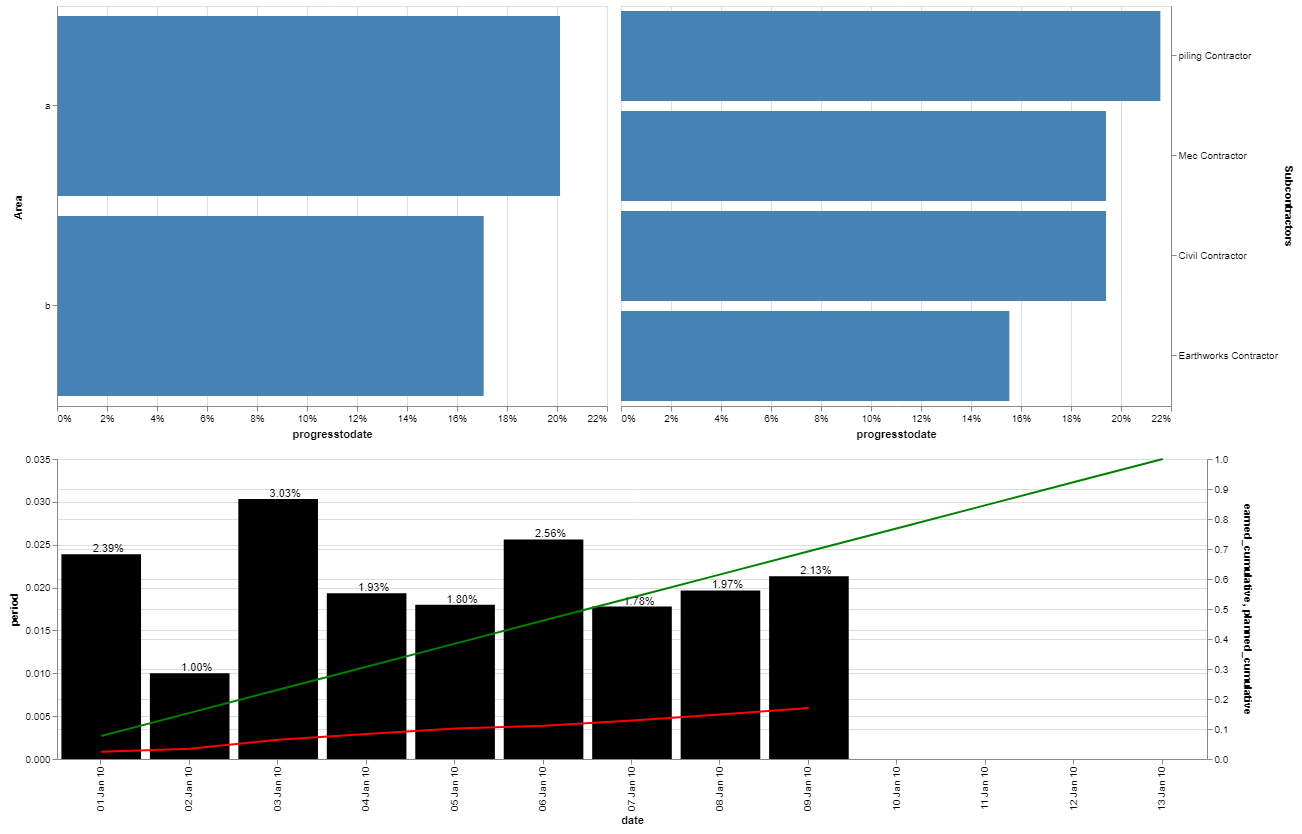

In [6]:
import altair as alt
import pandas as pd



#path='https://raw.githubusercontent.com/djouallah/vega-lite/master/data/earned.csv'
path='data/earned.csv'
df = alt.UrlData(url=path, format=alt.CsvDataFormat(parse={'date': 'date:"%e/%m/%Y"'}))


#df=pd.read_csv("data/earned_real_data.csv",parse_dates=[0], dayfirst=True)


pts = alt.selection(type='multi', encodings=['y'])
############################################################################
dropdown = alt.selection(type='multi', encodings=['y'])

bardropdown = alt.Chart(df).transform_aggregate(
    max_budget='sum(last_budget)',
    sum_Installed_qty='sum(earned)',
    groupby=['category2']
).transform_calculate(
    progresstodate='datum.sum_Installed_qty/ datum.max_budget'
).mark_bar().encode(
    y=alt.Y('category2:N',sort=alt.EncodingSortField(field="progresstodate", op="max", order='descending'),title="Area"),
    x=alt.X('progresstodate:Q',axis=alt.Axis(format='%')),
    color=alt.condition(dropdown, alt.ColorValue("steelblue"), alt.ColorValue("grey")),
    tooltip=[alt.Text('progresstodate:Q', format=',.2%'),'category2:N']

).properties(
    selection=dropdown,
    width=550,
    height=400
)  
#####################################################################################

barselect = alt.Chart(df).transform_filter(
    dropdown ).transform_aggregate(
    max_budget='sum(last_budget)',
    sum_Installed_qty='sum(earned)',
    groupby=['category']
).transform_calculate(
    progresstodate='datum.sum_Installed_qty/ datum.max_budget'
).mark_bar().encode(
    y=alt.Y('category:N',sort=alt.EncodingSortField(field="progresstodate", op="max", order='descending'),title="Subcontractors",axis=alt.Axis(orient="right")),
    x=alt.X('progresstodate:Q',axis=alt.Axis(format='%')),
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey")),
    tooltip=[alt.Text('progresstodate:Q', format=',.2%'),'category:N']

).properties(
    selection=pts,
    width=550,
    height=400
)  

#############################################################################
line_earned = alt.Chart(df).transform_filter(
    dropdown 
).transform_filter(pts
      ).transform_aggregate(
    sum_installed_cumulative='sum(earned_cumulative)',
    sum_planned_cumulative='sum(planned_cumulative)',
    sum_budget='sum(budget)',
    sum_baseline_budget='sum(baseline_budget)',
    sum_Installed_qty='sum(earned)',
    sum_type='sum(type)',
    groupby=['date']
).transform_calculate(
    earned_cumulative='if (datum.sum_type>0,datum.sum_installed_cumulative / datum.sum_budget,null)',
    planned_cumulative='if(datum.sum_baseline_budget > 0 ,datum.sum_planned_cumulative / datum.sum_baseline_budget,null)',
    period='if(datum.sum_Installed_qty >0,datum.sum_Installed_qty/ datum.sum_budget,null)'
).mark_line(color='red').encode(
    x=alt.X("date:O", timeUnit="yearmonthdate",axis=alt.Axis(format="%d %b %y"),title="date"),
    y='earned_cumulative:Q',
    tooltip=[alt.Text('earned_cumulative:Q',format=',.2%'),alt.Text('planned_cumulative:Q',format=',.2%')]
)
bar= line_earned.mark_bar(color='black').encode(
        y='period:Q'
)  
line_planned= line_earned.mark_line(color="green").encode(
        y='planned_cumulative:Q'
)  
text = bar.mark_text(
    align='center',
    baseline='bottom',
    dx=7  # Nudges text to right so it doesn't appear on top of the bar
                ).encode(text=alt.Text('period:Q', format=',.2%'))

combo = alt.layer(
    bar+ text,
    line_earned+line_planned
     ).resolve_scale(y='independent'
     ).properties(
    width=1150,
    height=300
)
    
###########################################################################    
chart= alt.vconcat(
    bardropdown | barselect,
    combo
).resolve_legend(
    color="independent",
    size="independent"
)
chart.save('docs/index.html')
chart
